# <center>AIM 5001 Project 2 (Module 7) (100 Points)</center>
# <center>Using PostgreSQL + Pandas for Data Management \& Analysis</center>
### <center>Sheng Han Yueh / Chi Kuang Chen</center>


In [3]:
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Part 1: Introduction (10 Points) 
__We gathered data from three different resources. The main table is the gas usage data recorded from 6 US states over the period 1967-1989. Besides the features in the gas table, we also gathered information on weather and latitude to discuss the effect of the two features on gas consumption. Our research questions focused on whether the price of substitutive energy affects the consumption of gas and what other features affect gas consumption.__

##  Part 2: Data Summary (10 Points)
__Source of the datasets:__  

* NaturalGas: retrieved from Data Sets - Vincent Arel-Bundock's Github projects  
    (https://vincentarelbundock.github.io/Rdatasets/datasets.html)  
* State: retrieved from USA Latitude and Longitude Map   
    (https://www.mapsofworld.com/lat_long/usa-lat-long.html)
* Weather: retrieved from National Centers for Environmental Information (NOAA)  
    (https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/)


__Variable Meaning and data type__ 

*NaturalGas Table:  the naturalgas table  include 10 attributes and 138 rows*
* State: character variable; state abbreviation.
* Statecode: integer variable; state Code.
* Year: integer variable; in which year.
* Consumption:  integer variable; consumption of natural gas by the residential sector
* Price: numeric / floating variable; price of natural gas
* Eprice: numeric / floating variable; price of electricity.
* Oprice: numeric / floating variable; price of distillate fuel oil.
* Lprice: numeric / floating variable; price of liquefied petroleum gas.
* Heating: Integer variable; heating degree days, the total number of degrees needed for the year to bring the average temperature up to 65°. 
* Income: numeric / floating variable; real per-capita personal income. 

*State Table: the state table  include 4 attributes and  6 rows*  
* State:character variable, represents state abbreviation.
* statecode:integer variable, represents the unique id of the state
* fullname:character variable, state full name without abbreviation
* Latitude:character variable,the midpoint latitude of state  

*Weather Table:  the weather table  include 3 attributes and 138 rows*
* state:character  variable, represents state abbreviation.
* year:Integer variable; factor coding year.
* ave_temp:numeric / floating variable; represent average temperature in Fahrenheit degree in certain state and certain year   



In [5]:
NaturalGas=pd.read_csv(r'D:\application for the usa\YU\3. Data Management\Module 7 Pandas Series & Dataframe Objects\project2\NaturalGas.csv',index_col=0)
State=pd.read_csv(r'D:\application for the usa\YU\3. Data Management\Module 7 Pandas Series & Dataframe Objects\project2\STATE.csv',index_col=False)
Weather=pd.read_csv(r'D:\application for the usa\YU\3. Data Management\Module 7 Pandas Series & Dataframe Objects\project2\Weather.csv',index_col=False)
Table_list=[NaturalGas,State,Weather]
Table_name=['NaturalGas','State','Weather']
for table, name in zip(Table_list,Table_name):
    print(f'{name}_table: {table.shape[1]} columns; {table.shape[0]} rows')
    print(table.dtypes)
    print()

NaturalGas_table: 10 columns; 138 rows
state           object
statecode        int64
year             int64
consumption      int64
price          float64
eprice         float64
oprice         float64
lprice         float64
heating          int64
income         float64
dtype: object

State_table: 4 columns; 6 rows
state        object
statecode     int64
full name    object
latitude     object
dtype: object

Weather_table: 3 columns; 138 rows
State        object
Date          int64
Ave_Temp    float64
dtype: object



## Part 3: Data Management using PostgreSQL (30 Points)

### <Task1 to 4> Create a fully normalized SQL database schema for the data you’ve chosen to work with. 
__The table NaturalGas contains two columns, state, and state code, that records the same information in the state. As a result, we created another table State to record the features of the state, which included abbreviations of the state name, state code, full name, and latitude. The abbreviation of the state is the primary key in the state table. After removing the state code in the NaturalGas table, we renamed the table as gas and made the state and year as the composite primary key. In addition to the two tables, we created a new table that recorded the average temperature in each year of each state from other data resources. The weather table has a composite primary key with state and year. The ER diagram is as the following figures.__  

__To create a new database, naturalgas, and the three new tables described above, we execute the following code within PostgreSQL server:__

CREATE DATABASE naturalgas; 

CREATE TABLE GAS(   
        state VARCHAR (10),  
        year INT,  
        consumption INT,  
        price DECIMAL,  
        eprice DECIMAL,  
        oprice DECIMAL,  
        lprice DECIMAL,  
        heating INT,  
        income DECIMAL,  
        __PRIMARY KEY (state,year)__);  
	
CREATE TABLE STATE(  
        __state VARCHAR (10) PRIMARY KEY,__    
        state_code INT,    
        fullname VARCHAR(100),  
        latitude VARCHAR(20));  

CREATE TABLE weather(  
        state VARCHAR (10),  
        year INT,  
        ave_Temp DECIMAL,  
        __PRIMARY KEY (state,year)__);  

### ER Diagram of NaturalGas Database
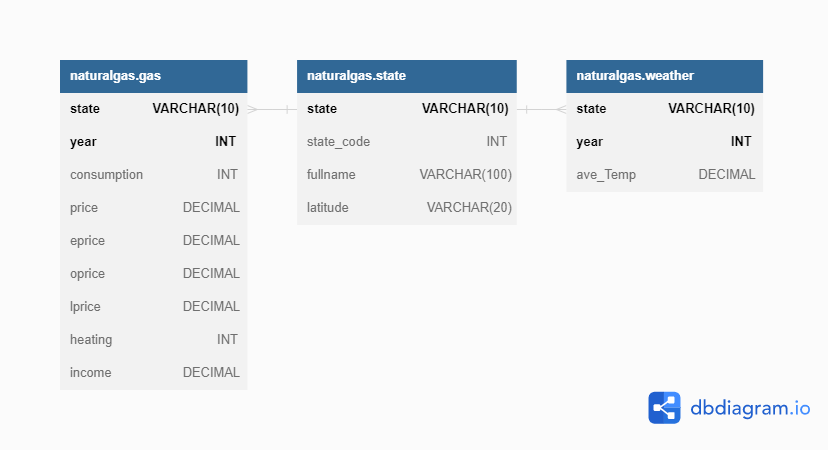

__Ref for ER diagram:__
* https://fmhelp.filemaker.com/help/18/fmp/en/index.html#page/FMP_Help/one-to-many-relationships.html  
* https://dbdiagram.io/d (using the link to create the ER diagram)

### <Task 5> Connect to your PostgreSQL server and load data set into new database
__We have read the three CSV files into a data frame with pd.read_csv() and created the database and tables with the PostgreSQL server. To import the data from CSV file into the database, we connected to SQL by psycopg2. We imported data row by row, using .iloc\[row number,:\] to read one row and all the columns at a time, transferring the value into a string to avoid the adaptation conflict. Results would be updated in the database by the command, conn.commit().__   

In [6]:
conn = psycopg2.connect(
    host="localhost",
    database="naturalgas",
    user="postgres",
    password="s25353725")
cur = conn.cursor()

__Import data into gas table__

In [ ]:
insert_cmd="""INSERT INTO "gas" VALUES (%s, %s, %s, %s, %s, %s, %s, %s,%s)"""
gas=NaturalGas.drop(columns=['statecode'])
for row in range(gas.shape[0]):
    data=[str(i) for i in gas.iloc[row,:].tolist()] # if we did not tranfer the data type, would have error, psycopg2: can't adapt type 'numpy.int64'
    cur.execute(insert_cmd,data)
    conn.commit()

__Import data into state table__

In [ ]:
insert_cmd="""INSERT INTO "state" VALUES (%s, %s, %s, %s)"""
for row in range(State.shape[0]):
    data=[str(i) for i in State.iloc[row,:].tolist()]
    cur.execute(insert_cmd,data)
    conn.commit()

__Import data into weather table__

In [ ]:
insert_cmd="""INSERT INTO "weather" VALUES (%s, %s, %s)"""
for row in range(Weather.shape[0]):
    data=[str(i) for i in Weather.iloc[row,:].tolist()]
    cur.execute(insert_cmd,data)
    conn.commit()

__Test__

* __The table gas and weather has 6 states that recorded 23 years of data. There will be 138 rows__  
* __The table state should have 6 rows__

In [7]:
table_list=['gas','state','weather']
for table in table_list:
    cur.execute(f"""SELECT COUNT(*) FROM "{table}" """)
    query_results = cur.fetchall()
    print(f'Table {table} has {query_results[0][0]} rows')

Table gas has 138 rows
Table state has 6 rows
Table weather has 138 rows


__Ref :__
* https://linuxhint.com/cursor-execute-python/
* https://www.dataquest.io/blog/sql-insert-tutorial/

### <Task 6> Read dataset from new PostgreSQL database into a new Pandas dataframe
__We utilized left join in sql query to combine full name of state, latitude of state, and temperature of each year with gas table__

In [8]:
sql_cmd="""SELECT "gas".* ,"state".fullname AS state_fullname,"state".latitude AS state_latitude,"weather".ave_temp
FROM "gas"
LEFT JOIN "state"
ON gas.state=state.state
LEFT JOIN "weather"
ON gas.state=weather.state AND gas.year=weather.year"""

df = pd.read_sql_query(sql_cmd, conn)

C:\Users\User\AppData\Local\Temp\ipykernel_14436\3204135677.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_cmd, conn)


In [9]:
# Display content of dataframe retrieved from naturalgas database
df

,state,year,consumption,price,eprice,oprice,lprice,heating,income,state_fullname,state_latitude,ave_temp
0,NY,1967,313656,1.42,2.98,7.40,1.47,6262,10903.75,New York,40°45'N,43.8
1,NY,1968,319282,1.38,2.91,7.77,1.42,6125,11370.02,New York,40°45'N,43.9
2,NY,1969,331326,1.37,2.84,7.96,1.38,6040,11578.68,New York,40°45'N,44.2
3,NY,1970,346533,1.40,2.87,8.33,1.37,6085,11586.77,New York,40°45'N,44.1
4,NY,1971,352085,1.50,3.07,8.80,1.40,5907,11657.42,New York,40°45'N,44.3
...,...,...,...,...,...,...,...,...,...,...,...,...
133,CA,1985,527495,5.72,7.78,30.58,5.84,2694,14368.46,California,37°30'N,57.3
134,CA,1986,464307,5.14,7.95,44.15,5.72,2192,14580.77,California,37°30'N,58.9
135,CA,1987,503473,5.26,8.03,35.24,5.14,2502,14915.05,California,37°30'N,58.3
136,CA,1988,497138,5.64,8.69,34.02,5.26,2366,15340.38,California,37°30'N,58.8


In [10]:
#Prepare the list of state 
cur.execute("""SELECT "state".state FROM state""")
query_results = cur.fetchall()
list_state=[i[0] for i in query_results]
print(list_state)

['NY', 'FL', 'MI', 'TX', 'UT', 'CA']


In [11]:
# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
cur.close()
conn.close()

## Part 4: Exploratory Data Analysis (EDA) (20 Points)

__We processed the latitude data, transferring the feature into numerical data__

In [12]:
import re

def degree_pro(x):
    data=re.search('(\d\d).([\d]+)\'[A-Z]+',x) # extract digits in the string
    res=int(data.group(1))+0.01*int(data.group(1)) # transfer into floating points
    return res

df['state_latitude']=df['state_latitude'].apply(degree_pro)

In [13]:
df['state_latitude']

0      40.40
1      40.40
2      40.40
3      40.40
4      40.40
       ...  
133    37.37
134    37.37
135    37.37
136    37.37
137    37.37
Name: state_latitude, Length: 138, dtype: float64

__The following table demonstrates the statistical summary of each feature. The price of distillate fuel oil has a larger std and is more expensive than other energy. The data on consumption, heating, and income varies a lot.__

In [14]:
df.describe()

,year,consumption,price,eprice,oprice,lprice,heating,income,state_latitude,ave_temp
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,1978.000000,252901.478261,3.422319,5.053551,24.635580,3.207681,4154.528986,11193.235652,36.865000,54.627536
std,6.657415,184478.131559,2.169215,2.577859,15.401018,2.124937,2451.998462,1906.726093,5.513459,10.187303
min,1967.000000,9430.000000,0.680000,1.980000,5.010000,0.680000,481.000000,7465.340000,28.280000,41.700000
25%,1972.000000,49103.500000,1.380000,2.432500,8.240000,1.257500,2081.500000,9637.165000,31.310000,44.625000
50%,1978.000000,300835.500000,2.775000,4.520000,19.865000,2.615000,4272.000000,11367.460000,38.380000,53.100000
75%,1984.000000,346428.750000,5.310000,7.282500,40.102500,5.192500,6498.000000,12125.335000,40.400000,64.375000
max,1989.000000,637289.000000,8.060000,10.860000,51.730000,7.870000,7440.000000,16425.330000,44.440000,71.500000


__Visualize the distribution of numerical data__

<AxesSubplot:>

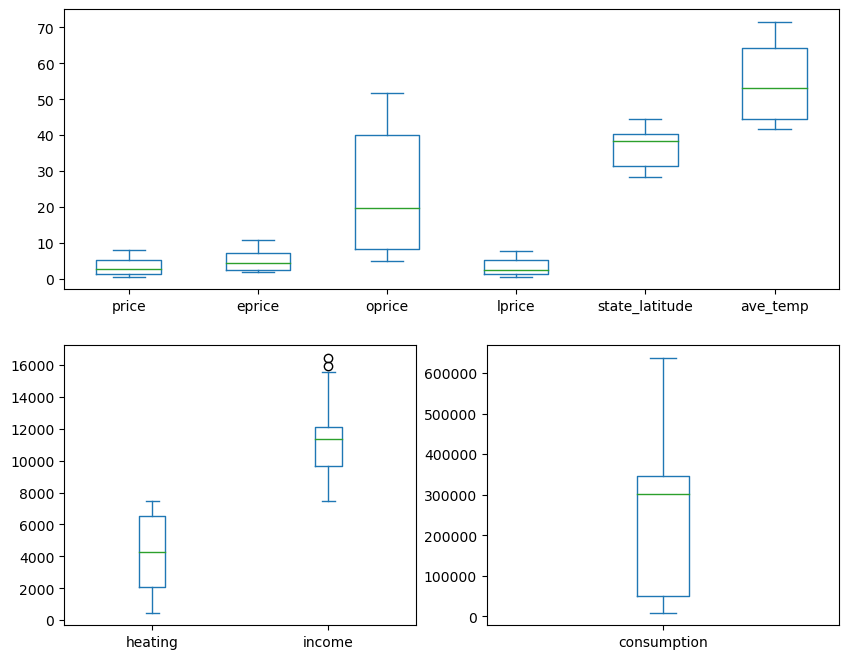

In [15]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)
df.loc[:,['price','eprice','oprice','lprice','state_latitude','ave_temp']].plot.box(ax=ax1)
df.loc[:,['heating','income']].plot.box(ax=ax2)
df.loc[:,['consumption']].plot.box(ax=ax3)

__Statistical summary data between 6 states__

In [16]:
for state in list_state:
    data=df[df.state==state].describe().mean()[1:]
    print(state,'(mean value)')
    print(data)
    print()

NY (mean value)
consumption       254293.604169
price                  6.380008
eprice                 8.323213
oprice                24.796526
lprice                 6.256823
heating             4523.420331
income              9831.288354
state_latitude        33.175000
ave_temp              36.351347
dtype: float64

FL (mean value)
consumption       11542.112670
price                 6.661726
eprice                6.818938
oprice               23.926456
lprice                6.496712
heating             570.051121
income             8350.178049
state_latitude       24.085000
ave_temp             55.534058
dtype: float64

MI (mean value)
consumption       259008.751173
price                  5.510674
eprice                 6.682334
oprice                23.468712
lprice                 5.442977
heating             5198.839818
income              8715.458985
state_latitude        36.205000
ave_temp              35.896584
dtype: float64

TX (mean value)
consumption       180119.768515
p

__Visualize the trends of numerical data during the 23 years and compared between 6 states__  
__The consumption of natural gas did not change a lot in Utah and California. The price of the four energy and income increased during the years. The energy price in new york state was higher than in other states most of the years. The number of heating degree days is related to the average temperature, the higher temperature, the less the number of heating degree days.__

In [17]:
import seaborn as sns

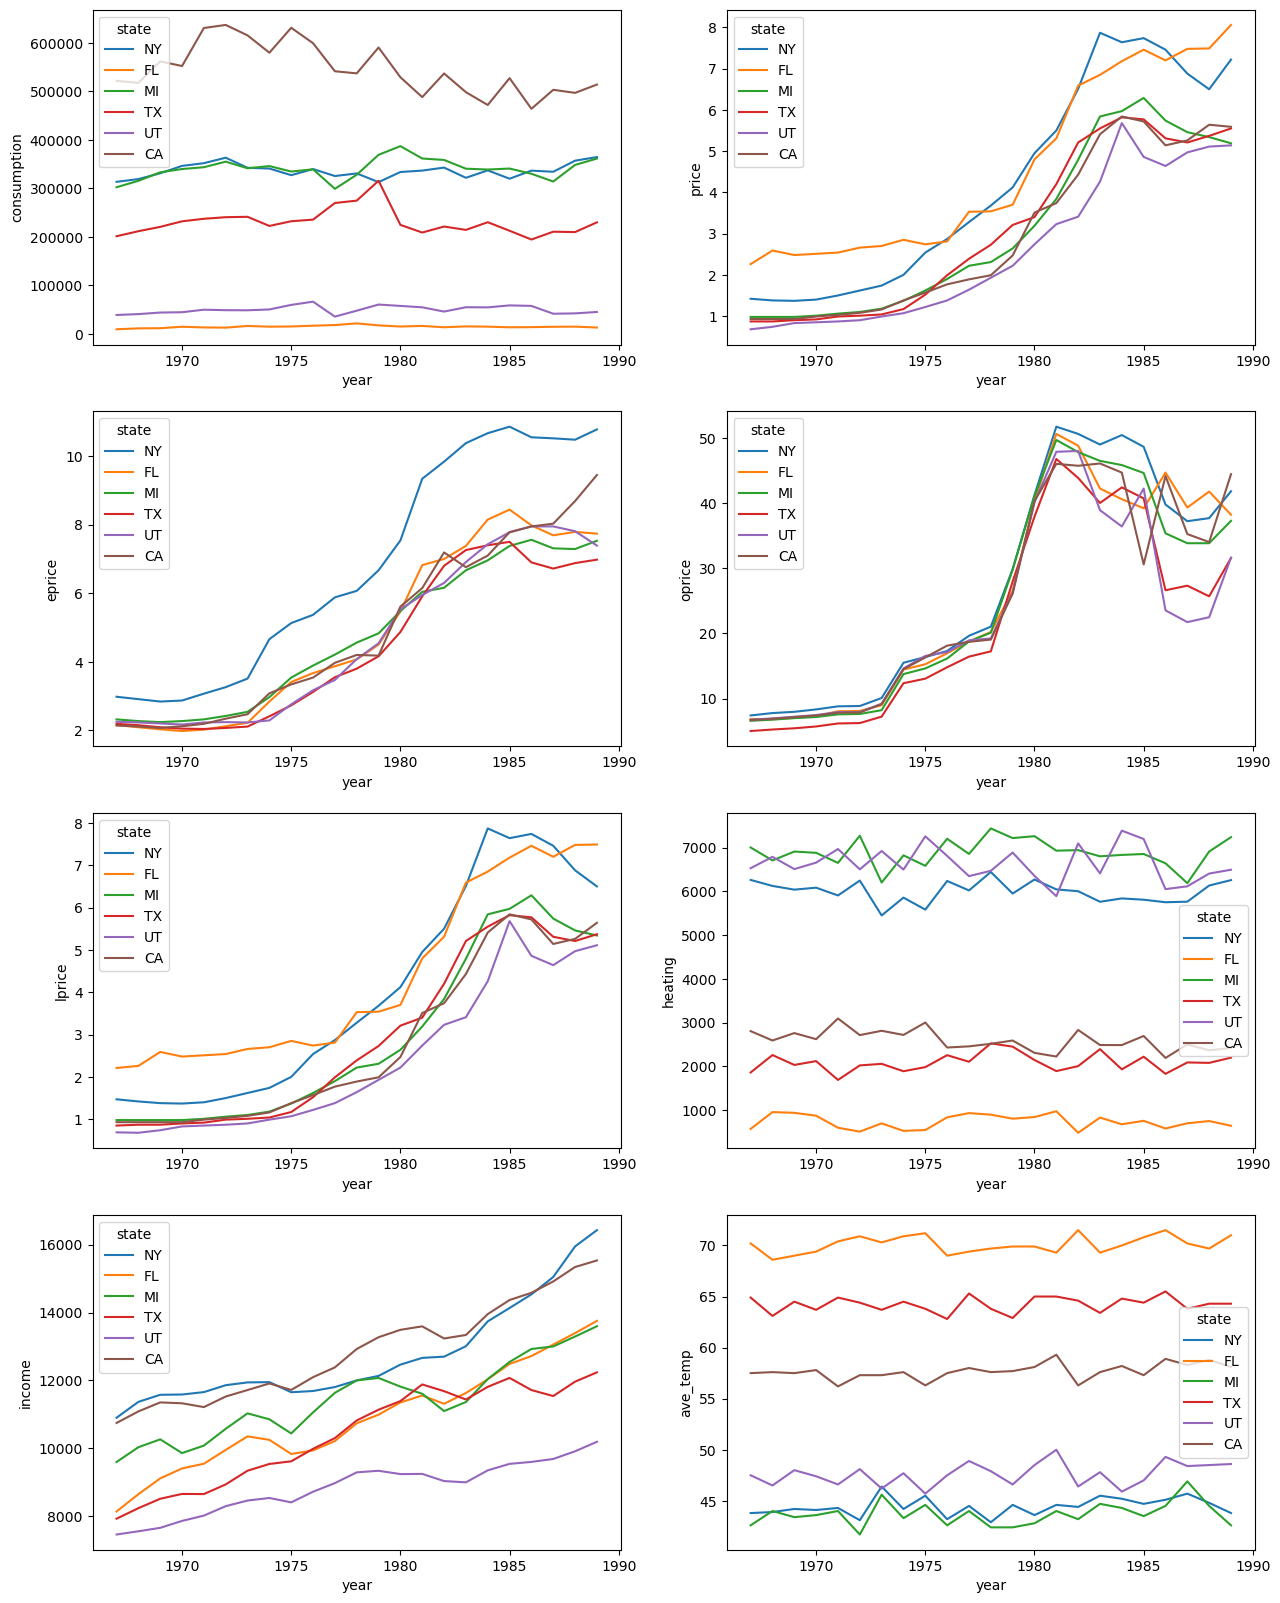

In [18]:
fig = plt.figure(figsize=(15,20))
nu_df=df.drop(columns=['state','year','state_fullname','state_latitude'])
for i in range(len(nu_df.columns)):
    ax = fig.add_subplot(4,2,i+1)
    sns.lineplot(data=df, x='year', y=nu_df.columns[i], hue='state',ax=ax)


### <Part 5>  Inference: perform analysis (20 Points)

__Using the following diagram, we attempted to illustrate and identify any colinearity problems for independent variables.__
* __Prices of four energy, income, and year are highly correlated with each other. That might be caused by inflation, and we saw the increasing trend between years from the line plot in part 4.__  
* __The latitude, average temperatures, and the number of heating degree days are highly correlated with each other, which met our expectations. That is to say, the three variables have redundant information. Therefore, we may discuss the effect of one of them on gas consumption.__  
* __The variable consumption has weak colinearity with other features accoring to the matrix.__ 

C:\Users\User\AppData\Local\Temp\ipykernel_14436\2258584059.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr(), dtype=bool))
C:\Users\User\AppData\Local\Temp\ipykernel_14436\2258584059.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True,mask=mask,vmin=-1, vmax=1)


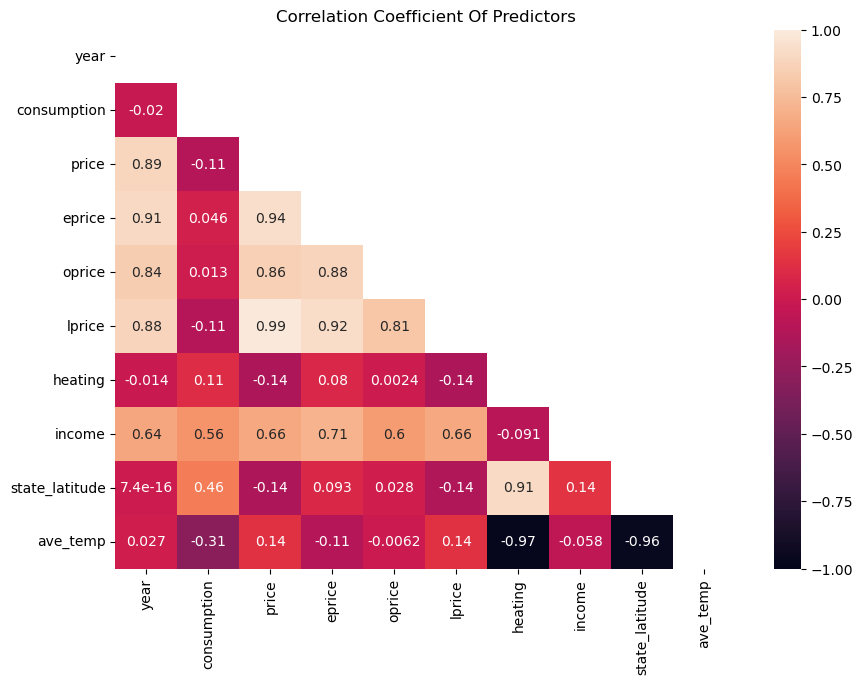

In [19]:
# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True,mask=mask,vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

__Ref :__ https://seaborn.pydata.org/generated/seaborn.heatmap.html

__The chart below shows the temperatue of the state and heating days relationship is almost negative perfectly correlated.__
__A negative, or inverse correlation, between two variables, indicates that one variable increases while the other decreases, and vice-versa. This relationship may or may not represent causation between the two variables, but it does describe an observable pattern.__
__From both diagram and correlation coefficient perspective. The correlation between heating degree days and temperature is negative and perfectly correlated. Based on the correlation coefficient of -0.97, it can be concluded that there will be a surge in heating needs when the temperature is lower.__

<AxesSubplot:xlabel='heating', ylabel='ave_temp'>

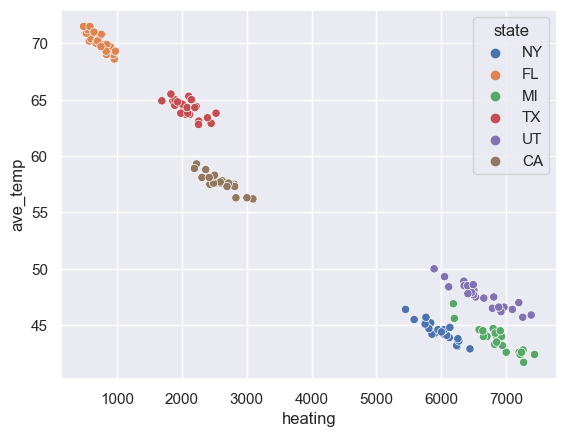

In [20]:
sns.set()
sns.scatterplot(data=df, x="heating", y="ave_temp", hue="state")

__By utilizing Multiple Regression model, we estimate the relationship between two or more independent variables.__
__Using the results of the multiple regression model, it appears that natural gas price, fuel price, heating degree days, income, and temperature have a significant impact on natural gas consumption. This is due to the fact that we observed that these independent variables have a low p-value (<0.05).__

In [21]:
# Dependent Variable: Natural Gas Consumption
# Indenpendent Variables: 'price', 'eprice', 'oprice', 'lprice', 'heating', 'income', 'ave_temp'

import statsmodels.api as sm
Y = df['consumption']
X = df[['price', 'eprice', 'oprice', 'lprice', 'heating', 'income', 'ave_temp']]
X = sm.add_constant(X)
ks = sm.OLS(Y, X)
ks_res =ks.fit()
ks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            consumption   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     81.28
Date:                Fri, 21 Oct 2022   Prob (F-statistic):           2.17e-44
Time:                        22:42:45   Log-Likelihood:                -1752.5
No. Observations:                 138   AIC:                             3521.
Df Residuals:                     130   BIC:                             3544.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.652e+06   4.94e+05      5.370      0.000    1.67e+06    3.63e+06
price      -6.545e+04   2.44e+04     -2.687      0.008   -1.14e+05   -1.73e+04
eprice     -1422.1044   1.21e+04     -0.117      0.907   -2.54e+04    2.25e+04
oprice      3650.7193   1132.908      3.222      0.002    1409.397    5892.042
lprice      6755.7577   2.29e+04      0.296      0.768   -3.85e+04     5.2e+04
heating     -157.5939     23.493     -6.708      0.000    -204.073    -111.115
income        50.9788      9.401      5.423      0.000      32.379      69.578
ave_temp   -4.019e+04   5868.356     -6.848      0.000   -5.18e+04   -2.86e+04
==============================================================================
Omnibus:                       10.696   Durbin-Watson:                   0.351
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                4.747
Skew:                           0.192   Prob(JB):                       0.0932
Kurtosis:                       2.176   Cond. No.                     8.59e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

__Ref:__ https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

__From the following scatter plots, we found the amount of consumption is highest in California. However, it is not the state with the highest heating degree days. We found income and the price of gas and fuel all interfere with the amount of consumption. The state with a high ratio of income to the price of energy had higher consumption.__  

<AxesSubplot:xlabel='heating', ylabel='consumption'>

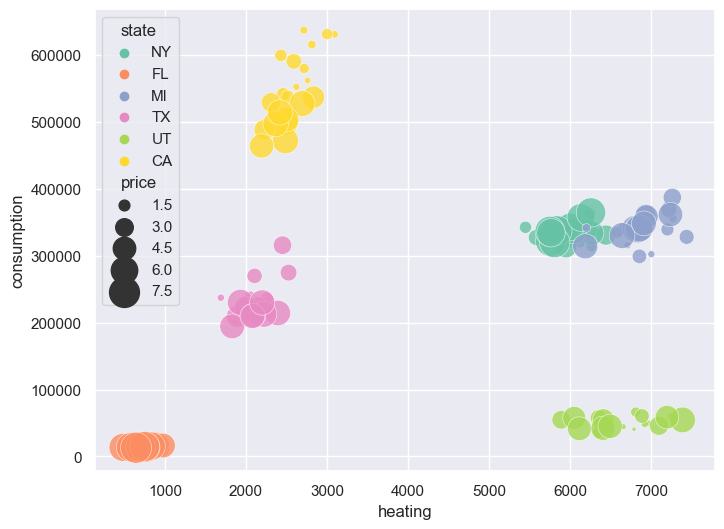

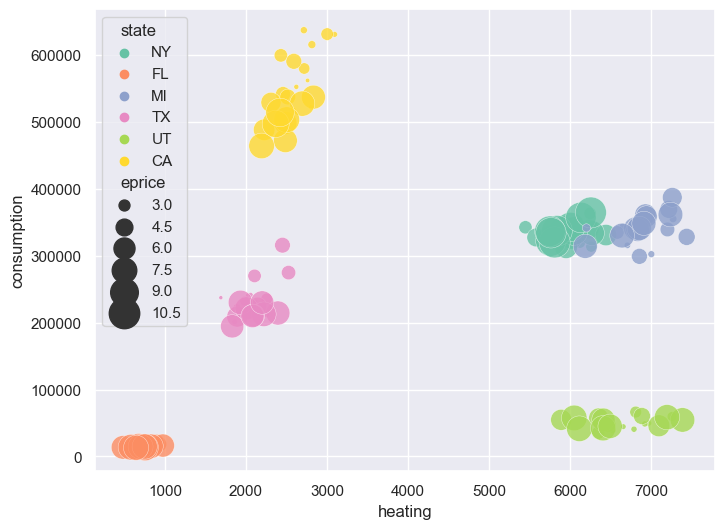

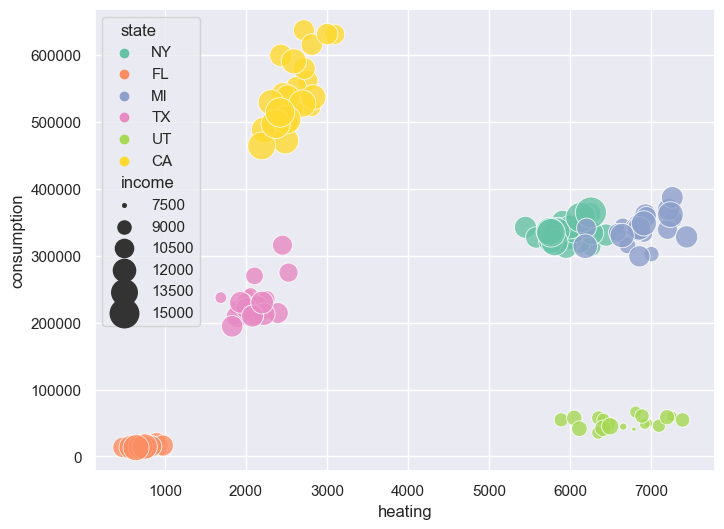

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="heating", y="consumption", hue="state",
                size="price",sizes=(5, 500),
                palette='Set2',alpha  = 0.8)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="heating", y="consumption", hue="state",
                size="eprice",sizes=(5, 500),
                palette='Set2',alpha  = 0.8)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="heating", y="consumption", hue="state",
                size="income",sizes=(5, 500),
                palette='Set2',alpha  = 0.8)

### <Part 6> Conclusion (10 Points)
__1.Due to substitution effect and income effect, natural gas consumption is positively impacted by fuel price and state    income, whenever the fuel price increased or state income increased, customers would seek higher natural gas consumption.__

__2.Likewise, since natural gas is a necessity for the household, we can observe that when natural gas prices rise, gas consumption decreases.__  

__3.As we are accustomed to thinking, when the weather is colder or the days require more opening of the furnace, it will be necessary to consume more natural gas as the source of energy to generate heat.__  


### We also found....
* __income growth rate: Overall, the income growth rate is 42.45493522870573 %__
* __income growth: As measured by dollar amount and income growth percentage, FL has the highest growth rate__

In [23]:
# In average - the 6 states in the database shows the following growth rate

gr = (df.income.iloc[-1] - df.income.iloc[0]) / df.income.iloc[0]
print("Overall, the income growth rate is",gr*100,"%")
df['income_growth_%'] = df.sort_values('year').groupby(['state'])['income'].pct_change(periods=22)
df['income_growth_$'] = df.sort_values('year').groupby(['state'])['income'].diff(periods=22)

(df.loc[df['year'] == 1989])

Overall, the income growth rate is 42.45493522870573 %


,state,year,consumption,price,eprice,oprice,lprice,heating,income,state_fullname,state_latitude,ave_temp,income_growth_%,income_growth_$
22,NY,1989,364713,7.22,10.78,41.82,6.50,6258,16425.33,New York,40.40,43.8,0.506393,5521.58
45,FL,1989,13089,8.06,7.74,38.21,7.49,642,13754.75,Florida,28.28,71.0,0.689084,5611.43
68,MI,1989,361667,5.19,7.53,37.28,5.34,7240,13596.79,Michigan,44.44,42.6,0.416275,3996.40
91,TX,1989,230099,5.55,6.98,31.57,5.37,2199,12238.59,Texas,31.31,64.3,0.543199,4307.93
114,UT,1989,45168,5.14,7.39,31.63,5.11,6495,10194.32,Utah,39.39,48.6,0.365553,2728.98
137,CA,1989,514276,5.59,9.45,44.44,5.64,2420,15532.93,California,37.37,58.1,0.444979,4783.34


* __The consumption of natural gas increased over the years__  
__The consumption of natural gas increased over the years from 1967 to 1989. We used simple regression model to explain - and we see the coefficient of the variable year is 127.8495. It means every year the consumption of natural gas increased around 127.8495 units. The r-squared of the model is 0.654. However, based on the mean of consumption, we can conclude that the growth of natural gas is very modest year over year.__

In [24]:
# Reference from this site Simple and Multiple Linear Regression in Python
# https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9

import statsmodels.api as sm

X = df["year"]
y = df["consumption"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model


# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            consumption   R-squared (uncentered):                   0.654
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              259.3
Date:                Fri, 21 Oct 2022   Prob (F-statistic):                    2.12e-33
Time:                        22:42:46   Log-Likelihood:                         -1868.6
No. Observations:                 138   AIC:                                      3739.
Df Residuals:                     137   BIC:                                      3742.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year         127.8495      7.940     16.102      0.000     112.149     143.550
==============================================================================
Omnibus:                       20.356   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.317
Skew:                           0.186   Prob(JB):                       0.0425
Kurtosis:                       2.020   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* __On the basis of the coefficient of variation (CV), FL has the highest level of volatility in gas consumption.__

In [25]:
# groupby columns on Col1 and estimate the std dev of column Col2 for each group
# df.groupby([Col1])[Col2].std()
# alternatively, you can pass 'std' to the agg() function
# df.groupby([Col1])[Col2].agg('std')

State_Consumption_Std = df.groupby(['state'])['consumption'].std()

State_Consumption_Mean = df.groupby(['state'])['consumption'].mean()

# Calculate coefficient of variation (CV)
# The coefficient of variation (CV) is defined as the ratio of the standard deviation to the mean. 
# It shows the extent of variability in relation to the mean of the population.

CV = State_Consumption_Std / State_Consumption_Mean
print(CV)

state
CA    0.094983
FL    0.170595
MI    0.060630
NY    0.042666
TX    0.116110
UT    0.159469
Name: consumption, dtype: float64


* __According to the line plot of price in part 4 and mean of gas prices for each state, the highest fuel prices in Florida is the most expensive.__

In [26]:
State_GasPrice_Mean = df.groupby(['state'])['price'].mean()
print(State_GasPrice_Mean)

state
CA    2.973913
FL    4.579565
MI    3.086957
NY    4.225652
TX    3.086957
UT    2.580870
Name: price, dtype: float64


* __Based on the results of the regression model, it appears that there is no strong correlation between heating degree days and state income. Observe that the points are scattered all over the place and diverge without forming a clear pattern. The regression model indicates that the variable coefficient is not significant.__

<AxesSubplot:xlabel='heating', ylabel='income'>

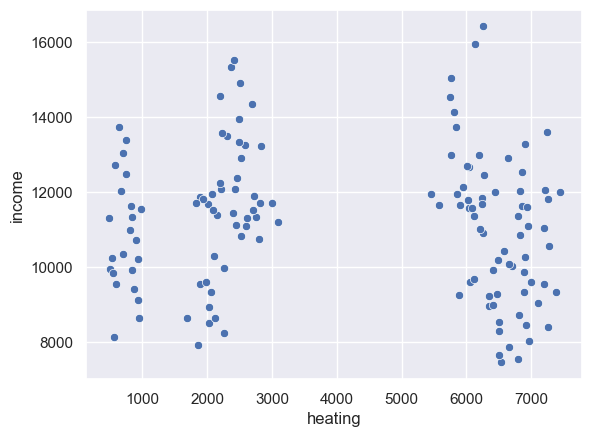

In [27]:
# The diagram illustrates the relationship betwee heating degree days and state income

sns.scatterplot(data=df, x="heating", y="income")

In [28]:
# Using a regression model that estimates the relationship between an independent variable (income) and a dependent variable (heating)

Y = df['heating']
X = df[['income']]
X = sm.add_constant(X)
ks = sm.OLS(Y, X)
ks_res =ks.fit()
ks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                heating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.123
Date:                Fri, 21 Oct 2022   Prob (F-statistic):              0.291
Time:                        22:42:48   Log-Likelihood:                -1271.8
No. Observations:                 138   AIC:                             2548.
Df Residuals:                     136   BIC:                             2553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5457.3485   1246.806      4.377      0.000    2991.714    7922.983
income        -0.1164      0.110     -1.060      0.291      -0.334       0.101
==============================================================================
Omnibus:                     1700.476   Durbin-Watson:                   0.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.151
Skew:                          -0.147   Prob(JB):                     0.000311
Kurtosis:                       1.350   Cond. No.                     6.78e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""